In [7]:
'''Modified from sklearn documentation: https://scikit-learn.org/stable/modules/compose.html
'''
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from pcsp import PCSPipeline, ModuleSet, Module # must install pcsp first (pip install pcsp)
from pcsp.pipeline import build_graph
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import sklearn
from functools import partial
import itertools
import networkx as nx
np.set_printoptions(threshold=5) # to limit printing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# basic pipeline

ModuleSet(hard_metrics)
ModuleSet(subsampling)
ModuleSet(modeling)
ModuleSet(subsampling)


/accounts/projects/vision/chandan/pcs-pipeline/pcsp/pipeline.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


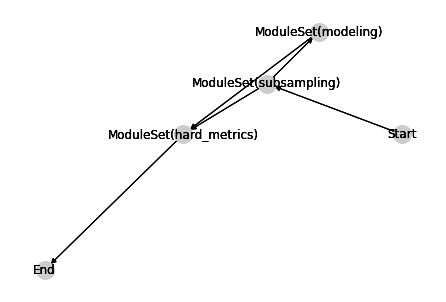

In [4]:
# subsample data
np.random.seed(13)
X, y = make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
subsampling_funcs = [partial(resample,
                            n_samples=int(X_train.shape[0]*0.3),
                            random_state=i)
                     for i in range(3)]
subsampling_set = ModuleSet(name='subsampling',
                            modules=subsampling_funcs)
# todo: shouldn't have to pass list for first args
X_all, y_all = subsampling_set([X_train], [y_train]) # subsampling_set([X_train, X_train], [y_train, y_train]) # artificially make it seem like there are multiple dsets (data_0 and data_1)

# fit models
modeling_set = ModuleSet(name='modeling',
                         modules=[LogisticRegression(max_iter=1000, tol=0.1),
                                  DecisionTreeClassifier()],
                         module_keys=["LR", "DT"])
models = modeling_set.fit(X_all, y_all)  # ModuleSet needs to store something for this call to work (makes models kind of useless)

# get predictions
X_all["test"] = X_test
y_all["test"] = y_test
preds_all = modeling_set.predict(X_all)

# get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[accuracy_score, balanced_accuracy_score],
                             module_keys=["Acc", "Bal_Acc"])
hard_metrics = hard_metrics_set.evaluate(y_all, preds_all)


# inspect the pipeline
# for k in hard_metrics:
#     print(k, hard_metrics[k])
G = build_graph(hard_metrics, draw=True)
plt.show()

# feature engineering pipeline
**this data set predicts boston house-preices dataset (regression)**

In [37]:
# get data as df
np.random.seed(13)
data = sklearn.datasets.load_boston()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)


def extract_feats(df: pd.DataFrame, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']):
    '''extract specific columns from dataframe
    '''
    print(feat_names, df.columns)
    return df[feat_names]

feat_extraction_funcs = [partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']),
                         partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE']),
                        ]
feat_extraction = ModuleSet(name='feat_extraction',
                            modules=feat_extraction_funcs)
X_all = feat_extraction([X_train, X_test]) # still weird that this is a list

['CRIM', 'ZN', 'INDUS', 'CHAS'] Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE'] Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
['CRIM', 'ZN', 'INDUS', 'CHAS'] Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE'] Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


# tracking things w Pipeline (deprecated)

In [4]:
p = PCSPipeline()

In [5]:
p.steps = [subsampling_set, modeling_set, hard_metrics_set] # how to deal w/ hard metrics?

In [6]:
p.run([X_train], [y_train])

subsampling
modeling
hard_metrics


In [7]:
p.steps[2].modules

{(('data_0', 'subsampling_0', 'LR'),
  ('data_0', 'subsampling_0'),
  'Acc'): 0.9090909090909091,
 (('data_0', 'subsampling_0', 'LR'),
  ('data_0', 'subsampling_0'),
  'Bal_Acc'): 0.8333333333333333,
 (('data_0', 'subsampling_0', 'DT'),
  ('data_0', 'subsampling_0'),
  'Acc'): 0.9090909090909091,
 (('data_0', 'subsampling_0', 'DT'),
  ('data_0', 'subsampling_0'),
  'Bal_Acc'): 0.8333333333333333,
 (('data_0', 'subsampling_1', 'LR'),
  ('data_0', 'subsampling_0'),
  'Acc'): 0.9090909090909091,
 (('data_0', 'subsampling_1', 'LR'),
  ('data_0', 'subsampling_0'),
  'Bal_Acc'): 0.8333333333333333,
 (('data_0', 'subsampling_1', 'DT'),
  ('data_0', 'subsampling_0'),
  'Acc'): 0.9090909090909091,
 (('data_0', 'subsampling_1', 'DT'),
  ('data_0', 'subsampling_0'),
  'Bal_Acc'): 0.8333333333333333,
 (('data_0', 'subsampling_2', 'LR'),
  ('data_0', 'subsampling_0'),
  'Acc'): 0.9090909090909091,
 (('data_0', 'subsampling_2', 'LR'),
  ('data_0', 'subsampling_0'),
  'Bal_Acc'): 0.8333333333333333,


In [8]:
# broken
#df = p.generate_names()
#df['hard_metrics'] = hard_metrics
#df